In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set batch size and transformation
batch_size = 50
symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h']
learning_rate = 0.025

In [4]:
# generate new boards and response with transformation
def get_symmetry(board, play_response, transformation):
    if transformation == 'rotate180':
        new_response = 8 - play_response
        return board[::-1], new_response
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(play_response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(play_response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(play_response)
        return board[6:9] + board[3:6] + board[0:3], new_response
    elif transformation == 'flip_h':  # flip_h = rotate180, then flip_v
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(play_response)
        new_board = board[::-1]
        return new_board[6:9] + new_board[3:6] + new_board[0:3], new_response
    else:
        raise ValueError('Method not implemented.')

In [6]:
# import best moves from csv
def get_moves_from_csv(csv_file):
    play_moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            play_moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return play_moves


In [7]:
# generate boards and best moves with transformation
def get_rand_move(play_moves, rand_transforms=2):
    (board, play_response) = random.choice(play_moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for _ in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, play_response) = get_symmetry(board, play_response, random_transform)
        #print(random_transform + '  ' + str(board) + '  ' + str(play_response))
    return board, play_response

## training set & testing set

In [8]:
# optimal moves
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')
# remove ambiguous strategy
moves.remove(([0, 0, 0, 0, 0, -1, 0, 0, 0], 6))
moves.remove(([-1, 0, 0, 0, -1, 0, 0, 0, 1], 6))
moves.remove(([0, -1, 1, 0, 1, -1, -1, 0, 0], 8))
moves.remove(([0, 0, -1, 0, 1, 0, -1, 0, 0], 5))
moves.remove(([1, 0, -1, -1, -1, 0, 1, 0, 0], 8))
moves.remove(([-1, 1, -1, 0, 1, 0, 0, 1, 0], 8))
moves.remove(([0, -1, 1, 0, 0, -1, 0, 0, 0], 7))
moves.remove(([1, -1, 1, 0, -1, 0, -1, 0, 0], 7))
moves.remove(([1, 0, 0, 0, -1, 0, 0, 0, -1], 6))
moves.remove(([0, -1, 0, 0, 0, 0, 0, 0, 0], 0))
moves.remove(([0, 0, 0, 0, -1, 0, 0, 0, 0], 0))

In [9]:
# Create train set:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

In [10]:
# Create a train set:
test_length = 200
test_set = []
for t in range(test_length):
    test_set.append(get_rand_move(moves))

In [11]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape))


def model(X, A1, A2, bias1, bias2, activation):
    if activation == 'sigmoid':
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    elif activation == 'relu':
        layer1 = tf.nn.relu(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return layer2

def model_3(X, A1, A2, A3, bias1, bias2, bias3, activation):
    if activation == 'sigmoid':
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
        layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, A2), bias2))
    elif activation == 'relu':
        layer1 = tf.nn.relu(tf.add(tf.matmul(X, A1), bias1))
        layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, A2), bias2))
    layer3 = tf.add(tf.matmul(layer2, A3), bias3)
    return layer3

def model_4(X, A1, A2, A3, A4, bias1, bias2, bias3, bias4, activation):
    if activation == 'sigmoid':
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
        layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, A2), bias2))
        layer3 = tf.nn.sigmoid(tf.add(tf.matmul(layer2, A3), bias3))
    elif activation == 'relu':
        layer1 = tf.nn.relu(tf.add(tf.matmul(X, A1), bias1))
        layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, A2), bias2))
        layer3 = tf.nn.relu(tf.add(tf.matmul(layer2, A3), bias3))
    layer4 = tf.add(tf.matmul(layer3, A4), bias4)
    return layer4


In [12]:
def run_model_1(train_set, test_set, N, activation):
    X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
    Y = tf.placeholder(dtype=tf.int32, shape=[None])

    A1 = init_weights([9, 81])
    bias1 = init_weights([81])
    A2 = init_weights([81, 9])
    bias2 = init_weights([9])

    #model_output = model(X, A1, A2, bias1, bias2)
    model_output = model(X, A1, A2, bias1, bias2, activation)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    prediction = tf.argmax(model_output, 1)

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    print('1 hidden layer model')
    loss_vec_2 = []
    accu_2 = []
    for i in range(N):
        rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
        batch_data = [train_set[i] for i in rand_indices]
        x_input = [x[0] for x in batch_data]
        y_target = np.array([y[1] for y in batch_data])
        sess.run(train_step, feed_dict={X: x_input, Y: y_target})

        temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
        loss_vec_2.append(temp_loss)
        if i % 2000 == 0:
            print('Iteration: {}, Loss: {}'.format(i, temp_loss))
        if i % 100 == 0 and i != 0:
            n = 0
            for test_data in test_set:
                test_boards = [test_data[0]]
                feed_dict = {X: test_boards}
                logits = sess.run(model_output, feed_dict=feed_dict)
                predictions = sess.run(prediction, feed_dict=feed_dict)
                #print(predictions)
                if predictions == test_data[1]:
                    #print(True)
                    n+=1

            accu_2.append(n/len(test_set))

    
    #accu_2 = get_accu(sess, test_set)
    print('Final accuracy: ', accu_2[-1])
    sess.close()
    return loss_vec_2, accu_2

In [13]:
def run_model_2(train_set, test_set, N, activation):
    X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
    Y = tf.placeholder(dtype=tf.int32, shape=[None])

    A1 = init_weights([9, 81])
    bias1 = init_weights([81])
    A2 = init_weights([81, 81])
    bias2 = init_weights([81])
    A3 = init_weights([81, 9])
    bias3 = init_weights([9])

    #model_output = model(X, A1, A2, bias1, bias2)
    model_output = model_3(X, A1, A2, A3, bias1, bias2, bias3, activation)

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    prediction = tf.argmax(model_output, 1)

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    print('2 hidden layer model')
    loss_vec_3 = []
    accu_3 = []
    for i in range(N):
        rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
        batch_data = [train_set[i] for i in rand_indices]
        x_input = [x[0] for x in batch_data]
        y_target = np.array([y[1] for y in batch_data])
        sess.run(train_step, feed_dict={X: x_input, Y: y_target})

        temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
        loss_vec_3.append(temp_loss)
        if i % 2000 == 0:
            print('Iteration: {}, Loss: {}'.format(i, temp_loss))
        if i % 100 == 0 and i != 0:
            n = 0
            for test_data in test_set:
                test_boards = [test_data[0]]
                feed_dict = {X: test_boards}
                logits = sess.run(model_output, feed_dict=feed_dict)
                predictions = sess.run(prediction, feed_dict=feed_dict)
                #print(predictions)
                if predictions == test_data[1]:
                    #print(True)
                    n+=1

            accu_3.append(n/len(test_set))

    
    #accu_2 = get_accu(sess, test_set)
    print('Final accuracy: ', accu_3[-1])
    sess.close()
    return loss_vec_3, accu_3

In [14]:
def run_model_3(train_set, test_set, N, activation):

    X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
    Y = tf.placeholder(dtype=tf.int32, shape=[None])

    A1 = init_weights([9, 81])
    bias1 = init_weights([81])
    A2 = init_weights([81, 81])
    bias2 = init_weights([81])
    A3 = init_weights([81, 81])
    bias3 = init_weights([81])
    A4 = init_weights([81, 9])
    bias4 = init_weights([9])


    #model_output = model(X, A1, A2, bias1, bias2)
    model_output = model_4(X, A1, A2, A3, A4, bias1, bias2, bias3, bias4, activation)

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    prediction = tf.argmax(model_output, 1)

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    print('3 hidden layer model')

    loss_vec_4 = []
    accu_4 = []
    for i in range(N):
        rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
        batch_data = [train_set[i] for i in rand_indices]
        x_input = [x[0] for x in batch_data]
        y_target = np.array([y[1] for y in batch_data])
        sess.run(train_step, feed_dict={X: x_input, Y: y_target})

        temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
        loss_vec_4.append(temp_loss)
        if i % 2000 == 0:
            print('Iteration: {}, Loss: {}'.format(i, temp_loss))
            
        if i % 100 == 0 and i != 0:
            n = 0
            for test_data in test_set:
                test_boards = [test_data[0]]
                feed_dict = {X: test_boards}
                logits = sess.run(model_output, feed_dict=feed_dict)
                predictions = sess.run(prediction, feed_dict=feed_dict)
                #print(predictions)
                if predictions == test_data[1]:
                    #print(True)
                    n+=1

            accu_4.append(n/len(test_set))

    
    #accu_2 = get_accu(sess, test_set)
    print('Final accuracy: ', accu_4[-1])
    sess.close()
    return loss_vec_4, accu_4

## Train models with all data labeled

### Sigmoid & Relu

In [15]:
N_generation = 10000
print('sigmoid')
loss_vec_1, accu_1 = run_model_1(train_set, test_set, N_generation, 'sigmoid')
loss_vec_2, accu_2 = run_model_2(train_set, test_set, N_generation, 'sigmoid')
loss_vec_3, accu_3 = run_model_3(train_set, test_set, N_generation, 'sigmoid')
print('relu')
loss_vec_1_relu, accu_1_relu = run_model_1(train_set, test_set, N_generation, 'relu')
loss_vec_2_relu, accu_2_relu = run_model_2(train_set, test_set, N_generation, 'relu')
loss_vec_3_relu, accu_3_relu = run_model_3(train_set, test_set, N_generation, 'relu')

sigmoid
1 hidden layer model
Iteration: 0, Loss: 8.523364067077637
Iteration: 2000, Loss: 1.0079435110092163
Iteration: 4000, Loss: 0.6067769527435303
Iteration: 6000, Loss: 0.44605717062950134
Iteration: 8000, Loss: 0.3332676291465759
Final accuracy:  0.905
2 hidden layer model
Iteration: 0, Loss: 10.344470977783203
Iteration: 2000, Loss: 0.4730135202407837
Iteration: 4000, Loss: 0.2791288495063782
Iteration: 6000, Loss: 0.10153762996196747
Iteration: 8000, Loss: 0.1178070455789566
Final accuracy:  0.94
3 hidden layer model
Iteration: 0, Loss: 5.5236334800720215
Iteration: 2000, Loss: 0.3713192641735077
Iteration: 4000, Loss: 0.16935424506664276
Iteration: 6000, Loss: 0.0774557888507843
Iteration: 8000, Loss: 0.04807150736451149
Final accuracy:  0.98
relu
1 hidden layer model
Iteration: 0, Loss: 22.994525909423828
Iteration: 2000, Loss: 0.146437406539917
Iteration: 4000, Loss: 0.032920628786087036
Iteration: 6000, Loss: 0.01995420828461647
Iteration: 8000, Loss: 0.016792604699730873
F

## Loss per generation

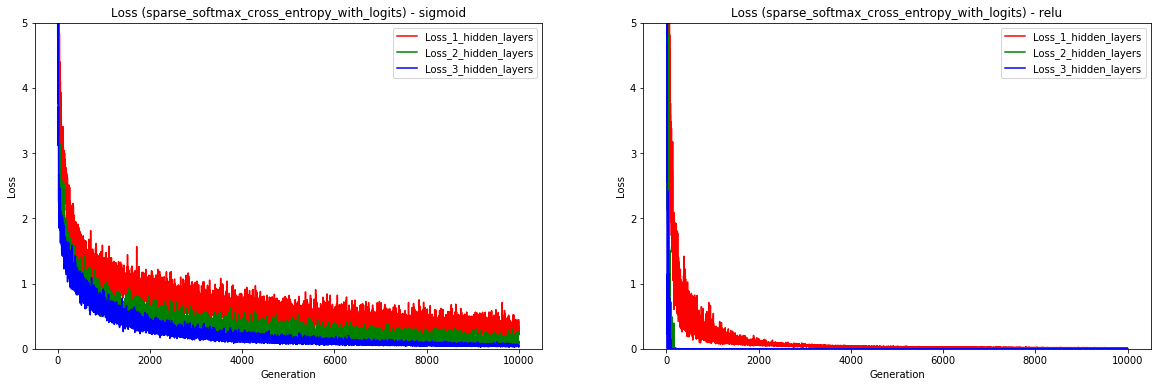

In [24]:
plt.rcParams["figure.figsize"] = [20,6]

# Plot loss
plt.subplot(121)
plt.plot(loss_vec_1, 'r', label='Loss_1_hidden_layers')
plt.plot(loss_vec_2, 'g', label='Loss_2_hidden_layers')
plt.plot(loss_vec_3, 'b', label='Loss_3_hidden_layers')
plt.title('Loss (sparse_softmax_cross_entropy_with_logits) - sigmoid')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0, 5)

plt.subplot(122)
plt.plot(loss_vec_1_relu, 'r', label='Loss_1_hidden_layers')
plt.plot(loss_vec_2_relu, 'g', label='Loss_2_hidden_layers')
plt.plot(loss_vec_3_relu, 'b', label='Loss_3_hidden_layers')
plt.title('Loss (sparse_softmax_cross_entropy_with_logits) - relu')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0, 5)

plt.show()

## Accuracy in test set per 100 generation

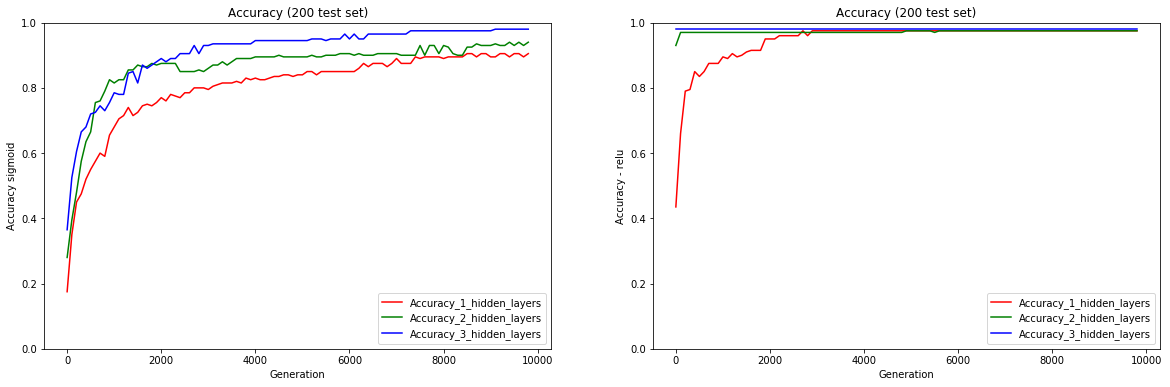

Sigmoid
Test set accuracy (1 fullly connected hidden layer): 0.905
Test set accuracy (2 fullly connected hidden layer): 0.94
Test set accuracy (3 fullly connected hidden layer): 0.98
Relu
Test set accuracy (1 fullly connected hidden layer): 0.975
Test set accuracy (2 fullly connected hidden layer): 0.975
Test set accuracy (3 fullly connected hidden layer): 0.98


In [25]:
plt.subplot(121)
y = [x * 100 for x in range(len(accu_1))]
plt.plot(y, accu_1, 'r', label='Accuracy_1_hidden_layers')
plt.plot(y, accu_2, 'g', label='Accuracy_2_hidden_layers')
plt.plot(y, accu_3, 'b', label='Accuracy_3_hidden_layers')
plt.title('Accuracy ({} test set)'.format(test_length))
plt.xlabel('Generation')
plt.ylabel('Accuracy sigmoid')
plt.legend(loc='lower right')
plt.ylim(0, 1)

plt.subplot(122)
plt.plot(y, accu_1_relu, 'r', label='Accuracy_1_hidden_layers')
plt.plot(y, accu_2_relu, 'g', label='Accuracy_2_hidden_layers')
plt.plot(y, accu_3_relu, 'b', label='Accuracy_3_hidden_layers')
plt.title('Accuracy ({} test set)'.format(test_length))
plt.xlabel('Generation')
plt.ylabel('Accuracy - relu')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

print('Sigmoid')
print('Test set accuracy (1 fullly connected hidden layer): {}'.format(accu_1[-1]))
print('Test set accuracy (2 fullly connected hidden layer): {}'.format(accu_2[-1]))
print('Test set accuracy (3 fullly connected hidden layer): {}'.format(accu_3[-1]))

print('Relu')
print('Test set accuracy (1 fullly connected hidden layer): {}'.format(accu_1_relu[-1]))
print('Test set accuracy (2 fullly connected hidden layer): {}'.format(accu_2_relu[-1]))
print('Test set accuracy (3 fullly connected hidden layer): {}'.format(accu_3_relu[-1]))

## Train model with half data labeled

In [18]:
int(len(moves)/2)

10

In [19]:
def remove_labels(moves, N):
    rand_indices = np.random.choice(range(len(moves)), (len(moves) - N), replace=False)
    moves_incomplete = [moves[i] for i in rand_indices]
    dropped_data = [data for data in moves if data not in moves_incomplete]
    train_length = 500
    train_set_incomplete = []
    for t in range(train_length):
        train_set_incomplete.append(get_rand_move(moves_incomplete))
    return train_set_incomplete, dropped_data

In [20]:
train_set_incomplete_drop_half, dropped_data_half = remove_labels(moves, int(len(moves)/2))
print('Removed:')
for data in dropped_data_half:
    print(str(data))
print('sigmoid')
loss_vec_1_drop_half, accu_1_drop_half = run_model_1(train_set_incomplete_drop_half, test_set, N_generation, 'sigmoid')
loss_vec_2_drop_half, accu_2_drop_half = run_model_2(train_set_incomplete_drop_half, test_set, N_generation, 'sigmoid')
loss_vec_3_drop_half, accu_3_drop_half = run_model_3(train_set_incomplete_drop_half, test_set, N_generation, 'sigmoid')

print('relu')
loss_vec_1_drop_half_relu, accu_1_drop_half_relu = run_model_1(train_set_incomplete_drop_half, test_set, N_generation, 'relu')
loss_vec_2_drop_half_relu, accu_2_drop_half_relu = run_model_2(train_set_incomplete_drop_half, test_set, N_generation, 'relu')
loss_vec_3_drop_half_relu, accu_3_drop_half_relu = run_model_3(train_set_incomplete_drop_half, test_set, N_generation, 'relu')

Removed:
([-1, 0, 0, 0, 0, 0, 0, 0, 0], 4)
([0, 0, 0, 0, 0, 0, 1, -1, -1], 3)
([0, 0, 1, 0, 0, -1, -1, 0, 0], 4)
([1, 0, 0, -1, 0, 0, 0, -1, 0], 2)
([0, 0, 0, -1, 0, 1, 1, -1, -1], 1)
([0, 0, -1, 1, 0, -1, 0, -1, 1], 0)
([1, -1, 0, 0, -1, 0, 0, 0, 0], 7)
([1, 0, -1, 0, -1, 0, 0, 0, 0], 6)
([1, -1, -1, 0, -1, 0, 0, 1, 0], 6)
([1, -1, 0, 0, -1, -1, 0, 1, 0], 3)
sigmoid
1 hidden layer model
Iteration: 0, Loss: 15.596424102783203
Iteration: 2000, Loss: 0.3656529188156128
Iteration: 4000, Loss: 0.2093038558959961
Iteration: 6000, Loss: 0.1769365668296814
Iteration: 8000, Loss: 0.1258118450641632
Final accuracy:  0.71
2 hidden layer model
Iteration: 0, Loss: 5.948647975921631
Iteration: 2000, Loss: 0.1603059619665146
Iteration: 4000, Loss: 0.07929778844118118
Iteration: 6000, Loss: 0.056057821959257126
Iteration: 8000, Loss: 0.03600618988275528
Final accuracy:  0.7
3 hidden layer model
Iteration: 0, Loss: 7.186689376831055
Iteration: 2000, Loss: 0.13242338597774506
Iteration: 4000, Loss: 0.0

## Loss per generation

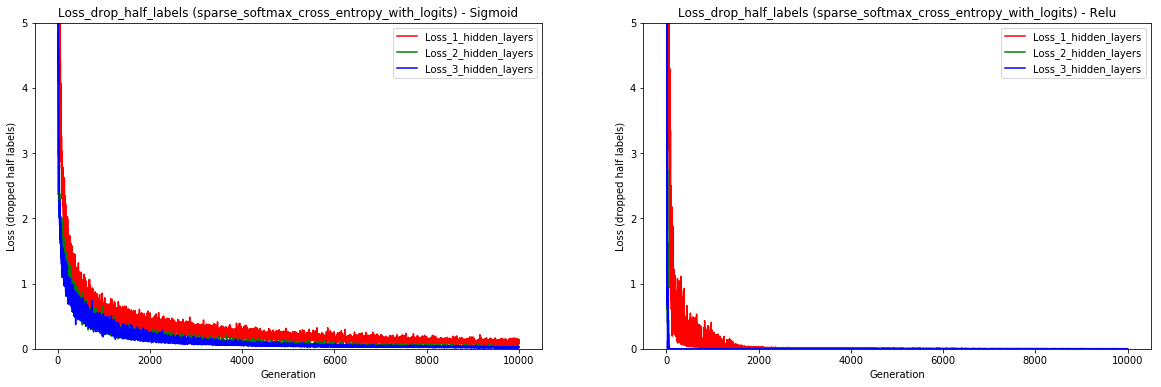

In [27]:
# Print loss
plt.subplot(121)
plt.plot(loss_vec_1_drop_half, 'r', label='Loss_1_hidden_layers')
plt.plot(loss_vec_2_drop_half, 'g', label='Loss_2_hidden_layers')
plt.plot(loss_vec_3_drop_half, 'b', label='Loss_3_hidden_layers')
plt.title('Loss_drop_half_labels (sparse_softmax_cross_entropy_with_logits) - Sigmoid')
plt.xlabel('Generation')
plt.ylabel('Loss (dropped half labels)')
plt.legend(loc='upper right')
plt.ylim(0, 5)

plt.subplot(122)
plt.plot(loss_vec_1_drop_half_relu, 'r', label='Loss_1_hidden_layers')
plt.plot(loss_vec_2_drop_half_relu, 'g', label='Loss_2_hidden_layers')
plt.plot(loss_vec_3_drop_half_relu, 'b', label='Loss_3_hidden_layers')
plt.title('Loss_drop_half_labels (sparse_softmax_cross_entropy_with_logits) - Relu')
plt.xlabel('Generation')
plt.ylabel('Loss (dropped half labels)')
plt.legend(loc='upper right')
plt.ylim(0, 5)

plt.show()

## Remove half (15) labels from training set

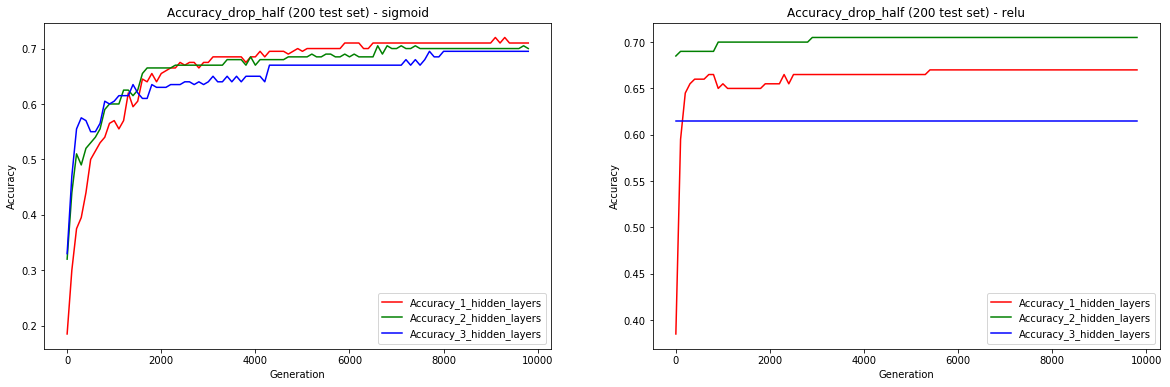

sigmoid
Test set accuracy (1 fullly connected hidden layer): 0.71
Test set accuracy (2 fullly connected hidden layer): 0.7
Test set accuracy (3 fullly connected hidden layer): 0.695
relu
Test set accuracy (1 fullly connected hidden layer): 0.67
Test set accuracy (2 fullly connected hidden layer): 0.705
Test set accuracy (3 fullly connected hidden layer): 0.615


In [26]:
y = [x * 100 for x in range(len(accu_1))]
plt.subplot(121)
plt.plot(y, accu_1_drop_half, 'r', label='Accuracy_1_hidden_layers')
plt.plot(y, accu_2_drop_half, 'g', label='Accuracy_2_hidden_layers')
plt.plot(y, accu_3_drop_half, 'b', label='Accuracy_3_hidden_layers')
plt.title('Accuracy_drop_half ({} test set) - sigmoid'.format(test_length))
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(y, accu_1_drop_half_relu, 'r', label='Accuracy_1_hidden_layers')
plt.plot(y, accu_2_drop_half_relu, 'g', label='Accuracy_2_hidden_layers')
plt.plot(y, accu_3_drop_half_relu, 'b', label='Accuracy_3_hidden_layers')
plt.title('Accuracy_drop_half ({} test set) - relu'.format(test_length))
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#print('Training set removed: ', str(dropped_data_half))
print('sigmoid')
print('Test set accuracy (1 fullly connected hidden layer): {}'.format(accu_1_drop_half[-1]))
print('Test set accuracy (2 fullly connected hidden layer): {}'.format(accu_2_drop_half[-1]))
print('Test set accuracy (3 fullly connected hidden layer): {}'.format(accu_3_drop_half[-1]))

print('relu')
print('Test set accuracy (1 fullly connected hidden layer): {}'.format(accu_1_drop_half_relu[-1]))
print('Test set accuracy (2 fullly connected hidden layer): {}'.format(accu_2_drop_half_relu[-1]))
print('Test set accuracy (3 fullly connected hidden layer): {}'.format(accu_3_drop_half_relu[-1]))

In [ ]:
# Create train set:
train_length = 5000
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move_1(moves))

train_set.sort()

a = ([-1, -1, 1, 0, -1, 0, 0, 1, 0], 8)
b = []
for i in train_set:
    if i[0] == a[0] and i[1] != a[1]:
        if i[2] not in b:
            b.append(i[2])
            print('moves.remove((',i[2],',', i[3],'))')
            #print('---')
        #print(i)

    a = i

In [ ]:
# generate boards and best moves with transformation
def get_rand_move_1(play_moves, rand_transforms=2):
   
    (board, play_response) = random.choice(play_moves)
    a = board
    b = play_response
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for _ in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, play_response) = get_symmetry(board, play_response, random_transform)
        #print(random_transform + '  ' + str(board) + '  ' + str(play_response))
    return board, play_response, a,b